In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from preprocessing.preprocessing_chagas import powerline_filter, emg_noise_filter, slide_cut_withpeaks, normalize

In [3]:
with open(r"d:\PKLs\chagas_unprocessed\x_val.pkl", "rb") as f:
    sample_signal = pickle.load(f)[0]
with open(r"d:\PKLs\chagas_unprocessed\y_val.pkl", "rb") as f:
    sample_label = pickle.load(f)[0]

In [ ]:
fs = 200
sample_signal = sample_signal[:fs * 60 * 2]
sample_signal = nk.signal_resample(sample_signal, sampling_rate=fs, desired_sampling_rate=128)
fs = 128
time = np.arange(len(sample_signal)) / fs

filtered_signal = powerline_filter(sample_signal)
filtered_signal = emg_noise_filter(filtered_signal)

In [15]:
peaks, info = nk.ecg_peaks(filtered_signal, sampling_rate=fs)
peaks_index = info["ECG_R_Peaks"]

In [35]:
class Config:
    def __init__(self):
        self.peak_method = "neurokit"
        self.has_limit = False

# beat segmented data
X, _, _ = slide_cut_withpeaks(
    np.array([filtered_signal]),
    np.array([sample_label]),
    10,
    10,
    percentage=0.5,
    frequency=fs,
    filters=["powerline", "emg"],
    current_config=Config(),
)
X = np.expand_dims(X, 1)
X = normalize(X)

peaks, info = nk.ecg_peaks(X[0], sampling_rate=fs)
segmented_peaks_index = info["ECG_R_Peaks"]

X.shape

(25, 1280)

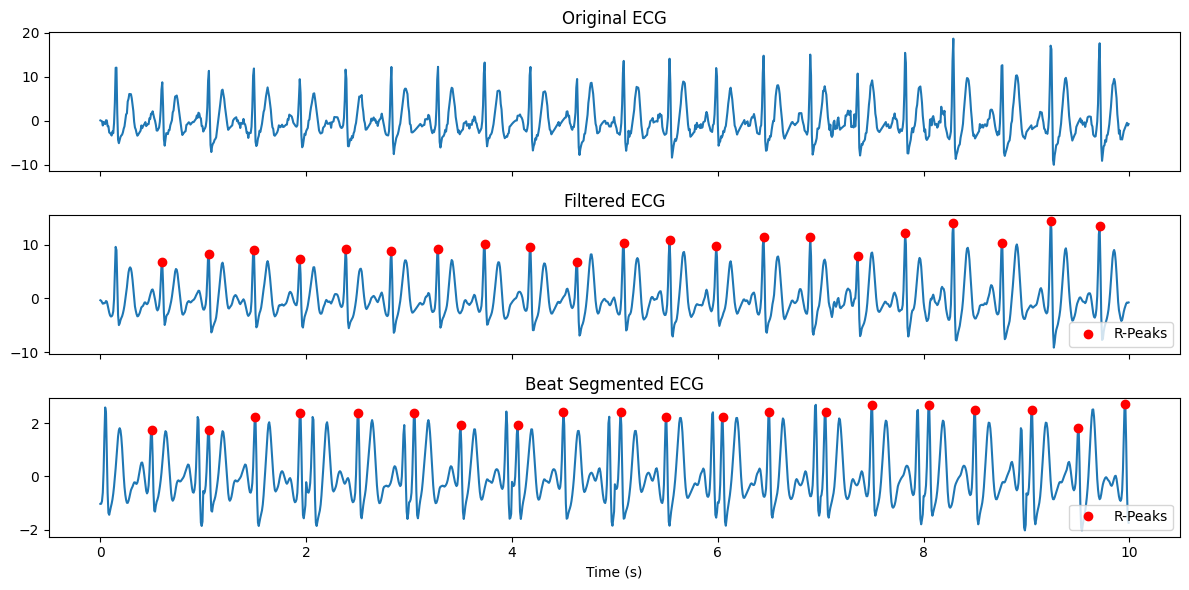

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
axes = axes.flatten()

duration = fs * 10
peaks_index = peaks_index[peaks_index < duration]
segmented_peaks_index = segmented_peaks_index[segmented_peaks_index < duration]

axes[0].plot(time[:duration], sample_signal[:duration])
axes[0].set_title("Original ECG")

axes[1].plot(time[:duration], filtered_signal[:duration])
axes[1].plot(time[:duration][peaks_index], filtered_signal[:duration][peaks_index], 'ro', label="R-Peaks")
axes[1].set_title("Filtered ECG")
axes[1].legend(loc=4)

axes[2].plot(time[:duration], X[0][:duration])
axes[2].plot(time[:duration][segmented_peaks_index], X[0][:duration][segmented_peaks_index], 'ro', label="R-Peaks")
axes[2].set_title("Beat Segmented ECG")
axes[2].set_xlabel("Time (s)")
axes[2].legend(loc=4)

plt.tight_layout()
# plt.savefig("demo_preprocessing.png", dpi=300, transparent=True)
plt.show()